# Ciclo 1: Health Insurance Cross-Sell

# Imports

In [3]:
pip install scikitplot

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [5]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
#import scikitplot as skplt


from sklearn import model_selection as ms
from sklearn import ensemble as en

import sklearn.neighbors as nh
import sklearn.linear_model as lm


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Data Load

In [6]:
conn = psycopg2.connect(
        host="comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com",
        database="comunidadedsdb",
        user="member",
        password="cdspa"

)

cur = conn.cursor()
        
#query = "select * from pa004.users"
#
#cur.execute(query)
#dados = cur.fetchall()
#dados

In [7]:
query = """select users.id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage,
                annual_premium,
                policy_sales_channel,
                vintage,
                response
            from pa004.users
                inner join pa004.insurance i on i.id = users.id
                inner join pa004.vehicle v on v.id = users.id"""

df = psql.read_sql(query, conn)
df.head()

C:\Users\thale\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


In [10]:
df.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [17]:
df_production = pd.read_csv('../data/test.csv')
df_production.columns = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage']

In [18]:
df_production = df_production.sample(500)
df_production.to_csv('dados_sheet.csv')

# 1.0 Descrição dos Dados

In [9]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [10]:
df1.shape

(381109, 12)

## 1.2 Tipo dos Dados

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check Na

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Alterar Tipo dos Dados

In [13]:
#df1['response'] = df1['response'].astype('str')

## 1.4 Análise Estatística

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


In [18]:
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 EDA

In [19]:
df3 = df2.copy()

In [20]:
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 3.1 Análise Univariada

<AxesSubplot:xlabel='response', ylabel='age'>

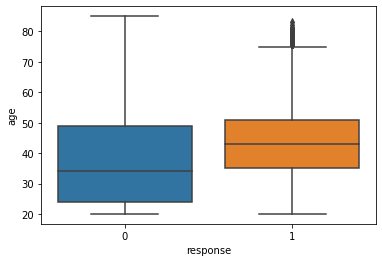

In [21]:
# age
sns.boxplot(x='response', y='age', data=df3)

<AxesSubplot:xlabel='age', ylabel='Count'>

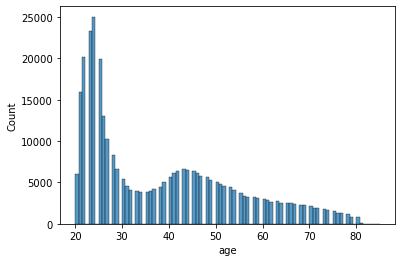

In [22]:
aux00 = df3.loc[df2['response'] == 0, 'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

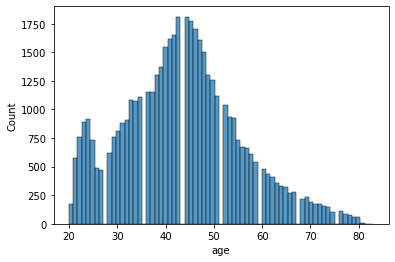

In [23]:
aux01 = df3.loc[df2['response'] == 1, 'age']
sns.histplot(aux01)

In [24]:
# gender

In [25]:
#driving_license
aux = df3[['driving_license','response']].groupby('response').sum().reset_index()
aux['driving_lic_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_lic_perc
0,0,333628,0.877283
1,1,46669,0.122717


<AxesSubplot:xlabel='region_code', ylabel='id'>

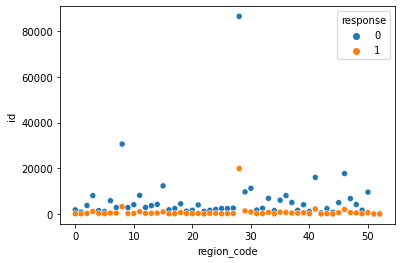

In [26]:
#region_code

aux0 = df3[['id', 'region_code', 'response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response', data=aux0)


In [27]:
#previously_insured
pd.crosstab(df3['previously_insured'], df3['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [28]:
#vehicle_age
df2[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


In [29]:
#vehicle_damage

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

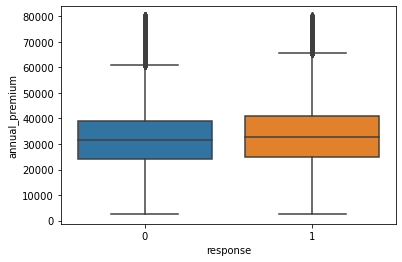

In [30]:
#annual_premium
aux = df3[df3['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

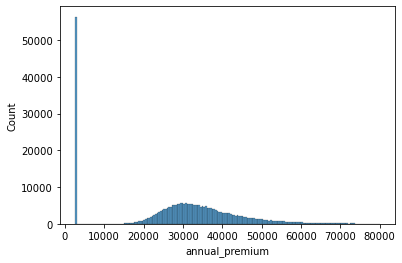

In [31]:
auxp0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(auxp0)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

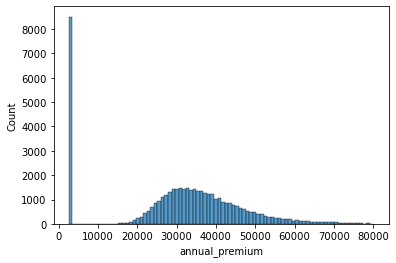

In [32]:
auxp1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(auxp1)

In [33]:
#policy_sales_channel

<AxesSubplot:xlabel='response', ylabel='vintage'>

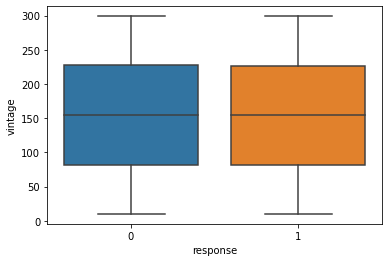

In [34]:
#vintage
#aux = df2[df2['annual_premium'] < 80000]
sns.boxplot(x='response', y='vintage', data=df3)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

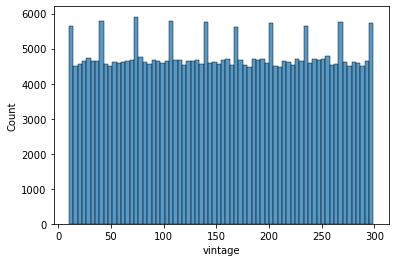

In [35]:
auxv0 = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot(auxv0)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

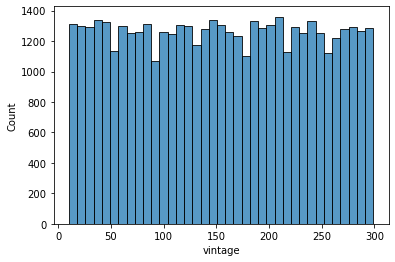

In [36]:
auxv1 = df3.loc[df2['response'] == 1, 'vintage']
sns.histplot(auxv1)

In [37]:
#response

- Hipóteses:

    - Pessoas mais jovens tem menor propensão a ter um seguro de carros
    - Mulheres tem maior propensão a ter seguro de carro
    - Pessoas com habilitação tem maior propensão a ter seguro de carro
    - Pessoas que ja possuem seguro de saude tem maiores chances de adquirir o seguro de carro
    - Pessoas que possuem carros com age < 1 tem maiores chances a adquirirem seguro de carro
    - Pessoas com vintage maior, possuem maiores chances de adquirirem seguro de carro
    - Pessoas que ja tiveram carros danificados no passado, tem maior aceitação de um seguro de carro

#### Pessoas mais jovens tem menor propensão a ter um seguro de carros

In [38]:
#sns.violinplot(data=df3, x="age", y="response")

#### Mulheres tem maior propensão a ter seguro de carro

<AxesSubplot:xlabel='gender', ylabel='response'>

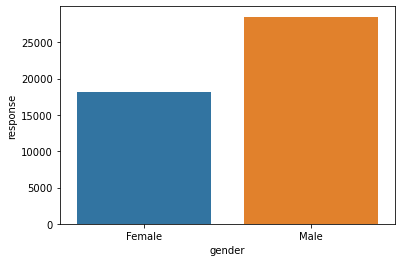

In [39]:
#df2.loc[df2['response'] == 1]

gender_response = df3[['gender', 'response']].loc[df3['response'] == 1].groupby('gender').count().reset_index()
sns.barplot(x='gender', y='response', data=gender_response)

#### Pessoas com habilitação tem maior propensão a ter seguro de carro

<AxesSubplot:xlabel='driving_license', ylabel='response'>

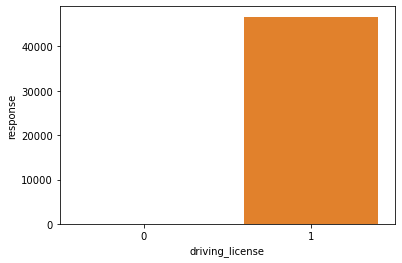

In [40]:
#df2.head()
driving_response = df3[['driving_license', 'response']].loc[df3['response'] == 1].groupby('driving_license').count().reset_index()
sns.barplot(x='driving_license', y='response', data=driving_response)

#### Pessoas que ja possuem seguro de saude tem maiores chances de adquirir o seguro de carro

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

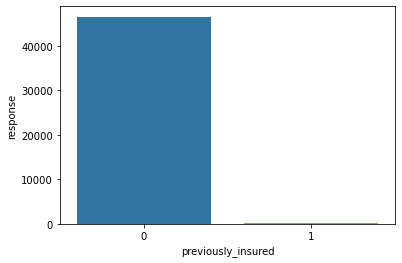

In [41]:
insured_response = df3[['previously_insured', 'response']].loc[df3['response'] == 1].groupby('previously_insured').count().reset_index()
sns.barplot(x='previously_insured', y='response', data=insured_response)

#### Pessoas que possuem carros com age < 1 tem maiores chances a adquirirem seguro de carro

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

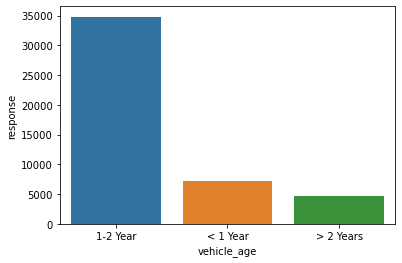

In [42]:
vehicle = df3[['vehicle_age', 'response']].loc[df3['response'] == 1].groupby('vehicle_age').count().reset_index()
sns.barplot(x='vehicle_age', y='response', data=vehicle)

#### Pessoas com vintage maior, possuem maiores chances de adquirirem seguro de carro

In [43]:
#sns.violinplot(data=df3, x="vintage", y="response")

#### Pessoas que ja tiveram carros danificados no passado, tem maior aceitação de um seguro de carro

<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

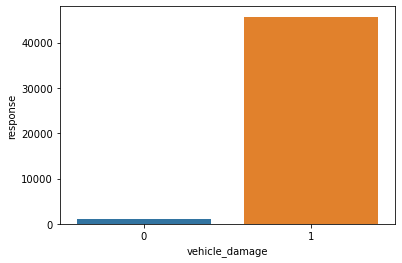

In [44]:
damage = df3[['vehicle_damage', 'response']].loc[df3['response'] == 1].groupby('vehicle_damage').count().reset_index()
sns.barplot(x='vehicle_damage', y='response', data=damage)

# 4.0 Data Preparation

In [45]:
df4 = df3.copy()

In [46]:
X = df3.drop('response', axis=1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20)

df4 = pd.concat([x_train,y_train],axis=1)

## 4.1 Standartization

In [47]:
ss =  StandardScaler()

# annual_premium

df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )

In [48]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
10835,86690,Female,50,1,15.0,0,1-2 Year,1,0.687642,26.0,22,0
279590,328552,Male,75,1,31.0,0,1-2 Year,1,-1.621616,124.0,65,0
101398,46597,Female,21,1,12.0,1,< 1 Year,0,0.100062,152.0,285,0
184069,328215,Male,55,1,28.0,0,1-2 Year,0,1.404809,26.0,107,0
97750,17526,Female,48,1,8.0,0,1-2 Year,1,0.556662,26.0,171,1


## 4.2 Reescalling

In [49]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()
# Age (Por não se parecer com uma normal)
df4['age'] = mms_age.fit_transform(df4[['age']].values)

# vintage
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)

In [50]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
10835,86690,Female,0.461538,1,15.0,0,1-2 Year,1,0.687642,26.0,0.041522,0
279590,328552,Male,0.846154,1,31.0,0,1-2 Year,1,-1.621616,124.0,0.190311,0
101398,46597,Female,0.015385,1,12.0,1,< 1 Year,0,0.100062,152.0,0.951557,0
184069,328215,Male,0.538462,1,28.0,0,1-2 Year,0,1.404809,26.0,0.335640,0
97750,17526,Female,0.430769,1,8.0,0,1-2 Year,1,0.556662,26.0,0.557093,1


## 4.3 Encoder

In [51]:
# gender
target_encoder_gender = df4.groupby('gender')['response'].mean()
df4.loc[:,'gender'] = df4['gender'].map(target_encoder_gender)

# region_code
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:,'region_code'] = df4['region_code'].map(target_encode_region_code)

# vehicle_age
df4 = pd.get_dummies(df4, prefix='vehicle_age',columns=['vehicle_age'])

# policy_sales_channel
fe_policy_sales_channel = df4.groupby('policy_sales_channel').size()/len(df4)
df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_sales_channel)

## 4.4 Validation Preparation


In [52]:
#gender
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].map(target_encoder_gender)

# region_code
x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

#policy_sales_chanel
x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# age
x_validation.loc[:,'age'] = mms_age.transform(x_validation[['age']].values)

# vintage
x_validation.loc[:,'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

#annual_premium
x_validation.loc[:,'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# fill na
x_validation = x_validation.fillna(0)


In [53]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
10835,86690,0.104504,0.461538,1,0.073718,0,1,0.687642,0.209025,0.041522,0,1,0,0
279590,328552,0.138031,0.846154,1,0.103210,0,1,-1.621616,0.194003,0.190311,0,1,0,0
101398,46597,0.104504,0.015385,1,0.095517,1,0,0.100062,0.353984,0.951557,0,0,1,0
184069,328215,0.138031,0.538462,1,0.187095,0,0,1.404809,0.209025,0.335640,0,1,0,0
97750,17526,0.104504,0.430769,1,0.095872,0,1,0.556662,0.209025,0.557093,1,1,0,0


# 5.0 Feature Selection

## 5.1 Feature Importance

In [54]:
forest = en.ExtraTreesClassifier(n_estimators=100, random_state=0,n_jobs=-1)

# data_preparation
x_train_n = df4.drop('response', axis=1)
y_train_n = y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

In [55]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]


print("importance rank")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0] )
    df = pd.concat([df,aux], axis=0)

print(df.sort_values('importance', ascending=False))

importance rank
                 feature  importance
0                     id    0.194310
0                vintage    0.187697
0         annual_premium    0.165114
0                    age    0.150930
0            region_code    0.090375
0         vehicle_damage    0.066654
0   policy_sales_channel    0.060260
0     previously_insured    0.056148
0   vehicle_age_< 1 Year    0.013396
0   vehicle_age_1-2 Year    0.006375
0                 gender    0.006355
0  vehicle_age_> 2 Years    0.001913
0        driving_license    0.000472


# 6.0 Machine Learning

In [56]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code','vehicle_damage','policy_sales_channel']

x_train = df4[cols_selected]
x_val = x_validation[cols_selected]

## 6.1 Knn

In [57]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=10 )

# model training
knn_model.fit(x_train,y_train)

# model prediction - Poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

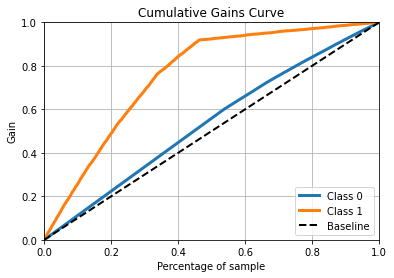

In [54]:
skplt.metrics.plot_cumulative_gain(y_validation,yhat_knn)

## 6.2 Logistic Regression

In [55]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train,y_train)

# model predict
yhat_lr = lr_model.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

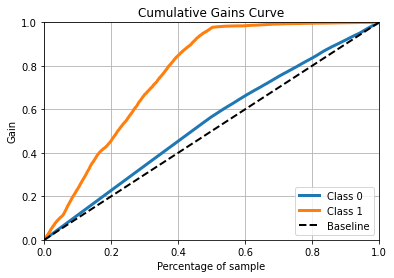

In [56]:
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr)

## 6.3 Random Forest

In [57]:
# model definition
model_rf = en.RandomForestClassifier(n_estimators = 100, random_state=42)
# model training
model_rf.fit(x_train,y_train)
# model predict
yhat_rf = model_rf.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

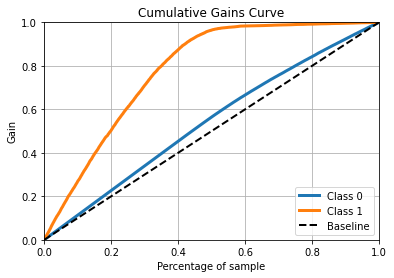

In [58]:
skplt.metrics.plot_cumulative_gain(y_validation,yhat_rf)

## 6.4 Extra Trees

In [59]:
# model definition
model_et = en.ExtraTreesClassifier( n_estimators= 100, random_state=42, n_jobs=-1 )

# model training
model_et.fit( x_train, y_train )

# model predict
yhat_et = model_et.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

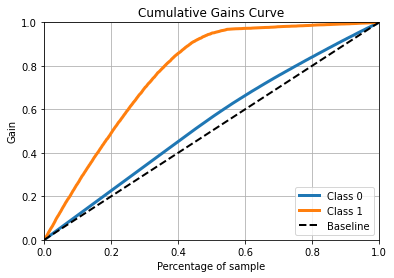

In [60]:
skplt.metrics.plot_cumulative_gain(y_validation,yhat_et)

# 7.0 Model Performance

In [83]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()
df8['score'] = yhat_knn[:,1].tolist()
df8 = df8[['id','response','score']].sort_values('score', ascending=False)

In [86]:
def precision_at_k(data, k= 2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k,'precision_at_k']

In [89]:
def recall_at_k(data, k= 2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k,'recall_at_k']

In [88]:
precision_at = precision_at_k(df8,k=50)
precision_at

0.43137254901960786

In [90]:
recall_at = recall_at_k(df8,k=50)
recall_at

0.0023666092943201377